# Source water use of trees and grasses using a PCA approach

In [1]:
import pandas as pd # for data manipulation and analysis
import numpy as np  # for mathematical functions
from scipy import stats as ss # to get standard error for plotting
from plotly import express as px # for plotting
import plotly.graph_objects as go # for pltting
import plotly.io as pio # for displaying images in github
from sklearn.preprocessing import StandardScaler # to scale values for PCA
from sklearn.decomposition import PCA # to run PCA
import statsmodels.formula.api as smf # to run ols and glm using the formula format
import statsmodels.api as sm # to run glm and specify family and link 
from statsmodels.stats.anova import anova_lm # to run anova
from statsmodels.graphics.api import qqplot # to check assumptions of anova
import matplotlib.pyplot as plt # to plot qqplot for anova assumptions
pio.renderers.default = "svg" # for graphs to show up in github

# Load the data

In [2]:
# use pandas to read the csv into python
df = pd.read_csv('isotope_data_example.csv')

In [3]:
# view the first 5 rows of data
df.head()

,Date,Sample ID,Plot,Treatment,Type,dD,d18O
0,3/28/17,1,1,cut,10_cm,-18,4.0
1,3/28/17,2,1,cut,10_cm,-12,2.8
2,3/28/17,3,1,cut,30_cm,-29,-1.2
3,3/28/17,4,1,cut,30_cm,-21,-0.2
4,3/28/17,5,1,cut,50_cm,-29,-1.3


We are interested in how $\delta D$ and $\delta ^{18}O$ vary among sample type (soil, tree, or grass) and treatment (plots with cut or uncut trees) in 2017 and 2018.

Variables:
* Date - There are 2 sampling dates. All samples were taken on the same day in 2017 and 2018.
* Sample_ID - The assigned number to each sample.
* Plot - There are 3 plots. Within each plot is a cut and an uncut treatment.
* Treatment - There are 2 treatments: cut and uncut. The cut treatment represents mopane trees that were subject to repeated removal of aboveground biomass. The uncut treatment is the control.
* Type - The sample type (tree, grass, or soil). The depths (cm) represent the depth of the soil sample.
* dD - $\delta D$
* d18O - $\delta ^{18}O$

We first need to clean the data to make the variables easier to work with in order to answer the questions.

# Clean data

In [4]:
# Extract the year from the Date column to easily compare between years.

# convert Date column into a datetime object
df["Date"] = pd.to_datetime(df["Date"], format="%m/%d/%y")

# extract year from Date
df.insert(1,"Year",df["Date"].dt.year)

In [5]:
# Here we can see the number of unique elements in the 'Type' column and a list of the elements
type_unique = df['Type'].nunique()
print('There are', type_unique, 'unique elements in the Type column')

print('Unique elements:', (df['Type'].unique()))

There are 7 unique elements in the Type column
Unique elements: ['10_cm' '30_cm' '50_cm' 'grass' 'tree' 'Borehole' 'pan_max']


In [6]:
# Remove the Borehole reference sample because it is not a sample of interest
df = df[df.Type != 'Borehole']

# pan_max is the species code for a type of grass, so we can replace 'pan_max' with 'grass'
df['Type'].replace('pan_max', 'grass', inplace=True)

In [7]:
# The Type column includes tree, grass and soil depth samples.
# We need to specify that anything that is not a tree or grass sample is a soil sample.

# create a new list called 'Type_2'
Type_2 = []

# use a for loop to specify that anything that is not tree or grass sample is a soil sample
for i in df['Type']:
    if i == 'tree':
        Type_2.append('tree')
    elif i == 'grass':
        Type_2.append('grass')
    else:
        Type_2.append('soil')

# add the Type_2 list as a new column to the dataframe
df['Type_2'] = Type_2

In [8]:
# extract the soil depths from the Type column into a new column called 'Depth'
df['Depth'] = df['Type'].str.split("_", n = 1, expand = True)[0]

# For plotting purposes, assign arbitrary depth values for tree and grass samples (see plot below)
df['Depth'].replace('tree', -20, inplace = True)
df['Depth'].replace('grass', -10, inplace=True)

# specify Depth column is numeric
# this will be important for analysis
df['Depth'] = pd.to_numeric(df['Depth'])

In the output below, we can see the results of the data cleaning and manipulation:
1. Year column with 2017 or 2018
2. Type_2 column with 'soil' in the rows with a soil depth in the Type column
3. Depth column with soil depth as an integer

In [9]:
df.head()

,Date,Year,Sample ID,Plot,Treatment,Type,dD,d18O,Type_2,Depth
0,2017-03-28,2017,1,1,cut,10_cm,-18,4.0,soil,10
1,2017-03-28,2017,2,1,cut,10_cm,-12,2.8,soil,10
2,2017-03-28,2017,3,1,cut,30_cm,-29,-1.2,soil,30
3,2017-03-28,2017,4,1,cut,30_cm,-21,-0.2,soil,30
4,2017-03-28,2017,5,1,cut,50_cm,-29,-1.3,soil,50


# Single isotope graphs
## Visualize - do soil water isotopes vary with depth?
In order to assess if water isotopes can be used as a indicator of depth of water uptake, we need to determine if soil water isotopes vary with depth. We expect isotopic values to get smaller with depth due to evaporative enrichment near the soil surface. 

From the plots below, we can see that on average both $\delta {^1}{^8}{O}$ and $\delta D$ decrease with depth. However, there is a lot of variation in 2018. In addition, tree samples tend to have lower values than grass samples.

### $\delta ^{18}{O}$

In [10]:
# create dataframe with mean and standard error for d18O isotopes for plotting
df_d18O = df.groupby(['Year', 'Type_2', 'Treatment', 'Depth'], as_index = False)['d18O'].agg([np.mean, ss.sem]).reset_index()

# plot d18O across soil depths
fig_d18O = px.scatter(df_d18O, x = 'mean', y = 'Depth', color = 'Type_2', error_x = 'sem',
                    facet_col = 'Year', facet_row = 'Treatment',
                    template = 'simple_white',
                    color_discrete_sequence = ["orange", "blue", "gray"],
                    category_orders = {"Type_2": ['tree', 'grass', 'soil']})
fig_d18O.update_xaxes(title_text = '\u03B4<sup>18</sup>O \u2030', row=1)
fig_d18O.update_yaxes(title_text = 'Depth (cm)', col = 1, autorange = 'reversed')
fig_d18O.update_layout(legend_title_text = 'sample type')
fig_d18O.for_each_annotation(lambda a: a.update(text = a.text.split("=")[-1]))
fig_d18O.show()

ValueError: 
The orca executable is required to export figures as static images,
but it could not be found on the system path.

Searched for executable 'orca' on the following path:
    /opt/anaconda3/bin
    /opt/anaconda3/condabin
    /google-cloud-sdk/bin
    /Applications/anaconda/bin
    //anaconda/bin
    /usr/local/bin
    /usr/bin
    /bin
    /usr/sbin
    /sbin
    /opt/X11/bin
    /Library/Frameworks/Mono.framework/Versions/Current/Commands

If you haven't installed orca yet, you can do so using conda as follows:

    $ conda install -c plotly plotly-orca

Alternatively, see other installation methods in the orca project README at
https://github.com/plotly/orca

After installation is complete, no further configuration should be needed.

If you have installed orca, then for some reason plotly.py was unable to
locate it. In this case, set the `plotly.io.orca.config.executable`
property to the full path of your orca executable. For example:

    >>> plotly.io.orca.config.executable = '/path/to/orca'

After updating this executable property, try the export operation again.
If it is successful then you may want to save this configuration so that it
will be applied automatically in future sessions. You can do this as follows:

    >>> plotly.io.orca.config.save()

If you're still having trouble, feel free to ask for help on the forums at
https://community.plot.ly/c/api/python


### $\delta D$

In [ ]:
# create dataframe with mean and standard error for dD isotopes for plotting
df_dD = df.groupby(['Year', 'Type_2', 'Treatment', 'Depth'], as_index = False)['dD'].agg([np.mean, ss.sem]).reset_index()

# plot dD across soil depths
fig_dD = px.scatter(df_dD, x = 'mean', y = 'Depth', color = 'Type_2', error_x = 'sem',
                    facet_col = 'Year', facet_row = 'Treatment',
                    template = 'simple_white',
                    color_discrete_sequence = ["orange", "blue", "gray"],
                    category_orders = {"Type_2": ['tree', 'grass', 'soil']})
fig_dD.update_xaxes(title_text = '\u03B4D \u2030', row = 1)
fig_dD.update_yaxes(title_text = 'Depth (cm)', col = 1, autorange = 'reversed')
fig_dD.update_layout(legend_title_text = 'sample type')
fig_dD.for_each_annotation(lambda a: a.update(text = a.text.split("=")[-1]))
fig_dD.show()

# Double Isotope Graph
### Plot soil, grass, and tree samples with the meteoric water line (MWL)
 From the double isotope graph below:
1. $\delta ^{18}{O}$ and $\delta{D}$ are highly correlated
2. Values fall beow the MWL indicating these samples are from a semi-arid region
3. Soil samples span the length of the graph while grass samples tend to be slightly more enriched than tree samples. However, some plants samples have lower values than the soil samples. This may indicate plants retrieved water from deeper soil depths than the depths sampled. 

In [11]:
# create data to plot meteoric water line
# This is the x variable
# Data needs to range from minimum value to maximum value of d18O
x = pd.Series(np.arange(df['d18O'].min(), df['d18O'].max(),1))

# Plug x into the meteoric water line equation to get the y variable
# Specify the y values as a dataframe
df_mwl = pd.DataFrame(8*x + 10)

# add x to the dataframe
df_mwl = pd.concat([df_mwl, x], axis=1)

# rename the x and y columns to d18O and dD, respectively
df_mwl.columns = ['dD', 'd18O']

In [12]:
# Plot samples
fig_mwl = px.scatter(df, x = 'd18O', y = 'dD', color = 'Type_2', 
                     facet_col = 'Year', facet_row = 'Treatment', 
                     template = 'simple_white',
                     trendline = 'ols',
                     color_discrete_sequence = ["orange", "blue", "gray"],
                     category_orders = {"Type_2": ['tree', 'grass', 'soil']})
fig_mwl.update_xaxes(title_text = '\u03B4<sup>18</sup>O \u2030', row = 1)
fig_mwl.update_yaxes(title_text = '\u03B4D \u2030', col = 1)
fig_mwl.update_layout(legend_title_text='sample type')
fig_mwl.for_each_annotation(lambda a: a.update(text=a.text.split("=")[-1]))

# Add MWL to graph
for i in range(1,3):
    fig_mwl.add_trace(go.Scatter(x = df_mwl['d18O'], y = df_mwl['dD'],
                    mode = 'lines',
                    line=dict(color='black'), showlegend=False), 1, i)
    fig_mwl.add_trace(go.Scatter(x = df_mwl['d18O'], y = df_mwl['dD'],
                    mode = 'lines',
                    line=dict(color='black'), showlegend=False), 2, i)
fig_mwl.show()

ValueError: 
The orca executable is required to export figures as static images,
but it could not be found on the system path.

Searched for executable 'orca' on the following path:
    /opt/anaconda3/bin
    /opt/anaconda3/condabin
    /google-cloud-sdk/bin
    /Applications/anaconda/bin
    //anaconda/bin
    /usr/local/bin
    /usr/bin
    /bin
    /usr/sbin
    /sbin
    /opt/X11/bin
    /Library/Frameworks/Mono.framework/Versions/Current/Commands

If you haven't installed orca yet, you can do so using conda as follows:

    $ conda install -c plotly plotly-orca

Alternatively, see other installation methods in the orca project README at
https://github.com/plotly/orca

After installation is complete, no further configuration should be needed.

If you have installed orca, then for some reason plotly.py was unable to
locate it. In this case, set the `plotly.io.orca.config.executable`
property to the full path of your orca executable. For example:

    >>> plotly.io.orca.config.executable = '/path/to/orca'

After updating this executable property, try the export operation again.
If it is successful then you may want to save this configuration so that it
will be applied automatically in future sessions. You can do this as follows:

    >>> plotly.io.orca.config.save()

If you're still having trouble, feel free to ask for help on the forums at
https://community.plot.ly/c/api/python


# PCA
The PCA analysis collapses the 2 water isotopes ($\delta ^{18}{O}$ and $\delta{D}$) into 1 axis. This allows us to test for differences in source water use between grass and tree samples and cut and uncut treatments even though the soil samples do not cover the entire range where plants uptake water. 

In [26]:
# define features for PCA. These are the 2 variables we are interested in collapsing into 1 axis.
features = ['d18O', 'dD']

# creates numpy array with d18O and dD values
x = df.loc[:, features].values

# Scale / normalize the d18O and dD values for PCA 
x = StandardScaler().fit_transform(x)

# specify number of PCA components
pca = PCA(n_components=2)

# this creates a numpy array with a PC1 value and a PC2 value for each row of the dataframe
principal_components = pca.fit_transform(x)

# Check that PC1 explains most of the variance
print('The variance explained by PC1 and PC2:', pca.explained_variance_ratio_)

The variance explained by PC1 and PC2: [0.91533816 0.08466184]


Here, PC1 explained approximately 91.5% of the variance, which is important since PC1 is the response variable to test for differences in the depth of water uptake between trees and grasses and cut and uncut treatments. This works because $\delta ^{18}{O}$ and $\delta{D}$ are highly correlated. 
<br>
<br>
Now we need to add a PC1 column to the clean dataframe.

In [27]:
# create pca dataframe with columns PC1 and PC2
pca_df = pd.DataFrame(data=principal_components, columns = ['PC1', 'PC2'])

# reset the index for each dataframe to properly concatenate the pca and cleaned dataframes in the correct order.
df.reset_index(drop=True, inplace=True)
pca_df.reset_index(drop=True, inplace=True)

# concatenate the pca dataframe with the original cleaned dataframe
df = pd.concat([df, pca_df], axis=1)

In the ouput below, the mean PC1 values for each soil depth tend to get larger with depth. However, in the single isotope graphs above isotopic values tend to get smaller with depth. In order to reflect the trends of the original data we need to use the negeative PC1 values. Remember, for the grass and tree samples, the depth is an arbitrary number. 

In [28]:
# Look at the mean PC1 values gropued by year, sample type, and soil depth.
print(df.groupby(['Year', 'Type_2', 'Depth'], as_index=False)['PC1'].agg([np.mean]))

                       mean
Year Type_2 Depth          
2017 grass  -10   -0.170465
     soil    10   -1.660700
             30   -0.258130
             50    0.136321
     tree   -20    1.104072
2018 grass  -10   -0.701725
     soil    10   -1.696948
             30   -1.156991
             50   -0.687270
     tree   -20    0.981389


In [29]:
# Use the negative of the PC1 axis to reflect the original data that lighter isotopes have smaller values.
df['PC1'] = -df['PC1']

In [30]:
# view the first 5 rows of the dataframe
df.head()

,Date,Year,Sample ID,Plot,Treatment,Type,dD,d18O,Type_2,Depth,PC1,PC2
0,2017-03-28,2017,1,1,cut,10_cm,-18,4.0,soil,10,1.507202,0.943190
1,2017-03-28,2017,2,1,cut,10_cm,-12,2.8,soil,10,1.579503,0.211028
2,2017-03-28,2017,3,1,cut,30_cm,-29,-1.2,soil,30,-0.659922,0.250918
3,2017-03-28,2017,4,1,cut,30_cm,-21,-0.2,soil,30,0.151329,-0.010450
4,2017-03-28,2017,5,1,cut,50_cm,-29,-1.3,soil,50,-0.687416,0.223423


## PCA Bar Plot

Plot mean PC1 for each treatment, plat type, and year to visualize differences in source water use. <br>

In graph below, smaller PC1 values represent water isotpoic values from deeper sources. Grass samples tend to have larger values than trees. Cut trees tend to have larger values than uncut trees.

In [31]:
# extract only grass and tree samples for plotting
df_plants = df.loc[(df['Type_2'] == 'grass') | (df['Type_2'] == 'tree')]

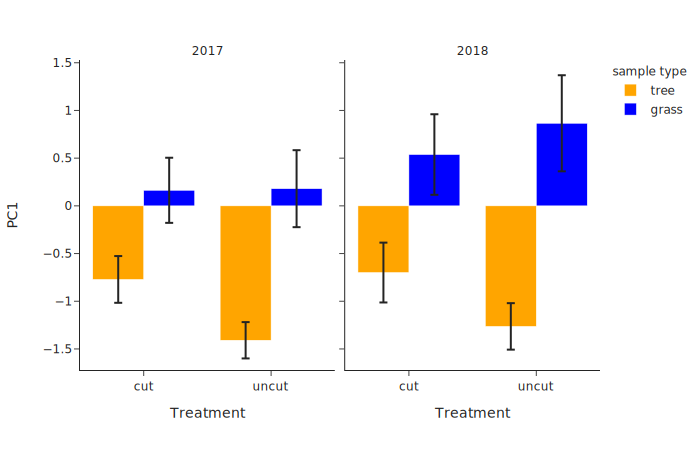

In [32]:
# create dataframe with mean and standard error for PC1 for plotting
df_pca_plot = df_plants.groupby(['Year', 'Type_2', 'Treatment'], as_index=False)['PC1'].agg([np.mean, ss.sem]).reset_index()

# Plot the average PC1 within each treatment and year
fig = px.bar(df_pca_plot, x='Treatment', y='mean', barmode = 'group', color='Type_2',
            error_y = 'sem',
            facet_col='Year',
            template='simple_white',
            color_discrete_sequence = ["orange", "blue"],
            category_orders = {"Type_2": ['tree', 'grass']})
fig.update_yaxes(title_text='PC1', col=1)
fig.update_layout(legend_title_text='sample type')
fig.for_each_annotation(lambda a: a.update(text=a.text.split("=")[-1]))
fig.show()


# Analyses using PC1 as the response variable

By plotting mean PC1 values by depth we can see the trend is very similar to the $\delta {^1}{^8}{O}$ and $\delta D$ single isotope plots above.

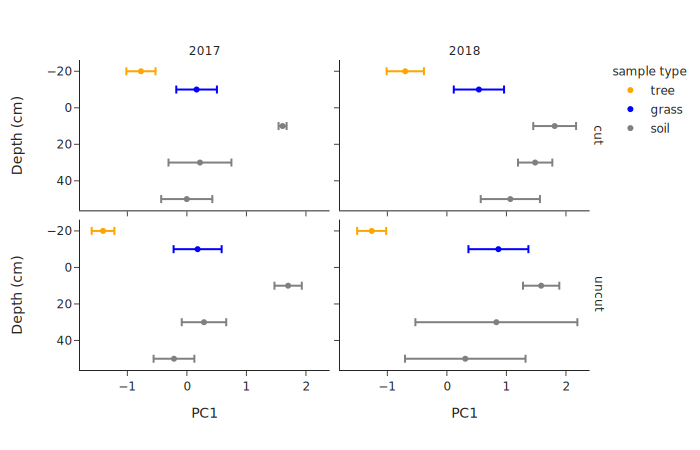

In [33]:
# create dataframe with mean and standard error for d18O isotopes for plotting
df_pc1_mean = df.groupby(['Year', 'Type_2', 'Treatment', 'Depth'], as_index=False)['PC1'].agg([np.mean, ss.sem]).reset_index()

# plot mean PC1 across soil depths
fig_pc1 = px.scatter(df_pc1_mean, x = 'mean', y = 'Depth', color = 'Type_2', error_x = 'sem', 
                     facet_col = 'Year', facet_row = 'Treatment',
                     template = 'simple_white',
                     color_discrete_sequence = ["orange", "blue", "gray"],
                     category_orders = {"Type_2": ['tree', 'grass', 'soil']})
fig_pc1.update_yaxes(title_text='Depth (cm)', col=1, autorange = 'reversed')
fig_pc1.update_xaxes(title_text = 'PC1', row=1)
fig_pc1.update_layout(legend_title_text='sample type')
fig_pc1.for_each_annotation(lambda a: a.update(text=a.text.split("=")[-1]))
fig_pc1.show()

## Do soil PC1 values vary with depth?
### Regression of PC1 soil samples against depth and year
To test if PC1 values vary with depth, regress PC1 against depth. The Depth*Year interaction allows us to account for differences in fractionation due to evaporation between sampling dates, which may result in a different response of how isotopes vary with soil depth.

In [34]:
# subset the data to only include soil samples
df_soil = df.loc[df['Type_2'] == 'soil']

In the linear regression below, there is no significant interaction between depth and year. Depth is a significant predictor of PC1, but year is not.

In [35]:
# run a regression with Depth and Year as a predictor for PC1
# define year as a categorical variable using 'C()'
lm_pc1 = smf.ols('PC1~Depth*C(Year)', data = df_soil).fit()
lm_pc1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    PC1   R-squared:                       0.376
Model:                            OLS   Adj. R-squared:                  0.324
Method:                 Least Squares   F-statistic:                     7.232
Date:                Wed, 06 May 2020   Prob (F-statistic):           0.000641
Time:                        14:25:29   Log-Likelihood:                -51.617
No. Observations:                  40   AIC:                             111.2
Df Residuals:                      36   BIC:                             118.0
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                 1.9330      0.420      4.604      0.000       1.081       2.785
C(Year)[T.2018]           0.0047      0.621      0.008      0.994      -1.254       1.263
Depth                    -0.0444      0.012     -3.704      0.001      -0.069      -0.020
Depth:C(Year)[T.2018]     0.0191      0.018      1.066      0.294      -0.017       0.056
==============================================================================
Omnibus:                        8.575   Durbin-Watson:                   1.051
Prob(Omnibus):                  0.014   Jarque-Bera (JB):                8.695
Skew:                          -0.714   Prob(JB):                       0.0129
Kurtosis:                       4.783   Cond. No.                         183.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Typcially, the log of soil depth provides a better fit for soil water isotopes because there is a larger change in isotopic values near the soil surface. This is because evaporative enrichment is largest at the soil surface and differences in isotopic values decrease with soil depth. Here, using log(depth) in the model provides a slightly better fit, but the results and interpretation are the same as the linear model.

In [36]:
# take the log of the depth column and create a new column called 'Depth_log'
df_soil.insert(10, 'Depth_log', df['Depth'].apply(np.log))

In [37]:
# regress PC1 against log(Depth) and Year
lm_pc1 = smf.ols('PC1~Depth_log*C(Year)', data = df_soil).fit()
lm_pc1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    PC1   R-squared:                       0.396
Model:                            OLS   Adj. R-squared:                  0.346
Method:                 Least Squares   F-statistic:                     7.866
Date:                Wed, 06 May 2020   Prob (F-statistic):           0.000366
Time:                        14:25:33   Log-Likelihood:                -50.968
No. Observations:                  40   AIC:                             109.9
Df Residuals:                      36   BIC:                             116.7
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                     4.2413      0.956      4.435      0.000       2.302       6.181
C(Year)[T.2018]              -1.1194      1.419     -0.789      0.435      -3.997       1.758
Depth_log                    -1.1368      0.289     -3.931      0.000      -1.723      -0.550
Depth_log:C(Year)[T.2018]     0.5311      0.431      1.231      0.226      -0.344       1.406
==============================================================================
Omnibus:                        7.765   Durbin-Watson:                   1.047
Prob(Omnibus):                  0.021   Jarque-Bera (JB):                8.062
Skew:                          -0.611   Prob(JB):                       0.0178
Kurtosis:                       4.829   Cond. No.                         44.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Visualizing this relationship, PC1 values tend to decrease with soil depth. There is a stronger relationship between the log(depth) and PC1 in 2017 than 2018. Differences between years in soil water isotopic values may be due to time since the last rainfall when samples were collected.

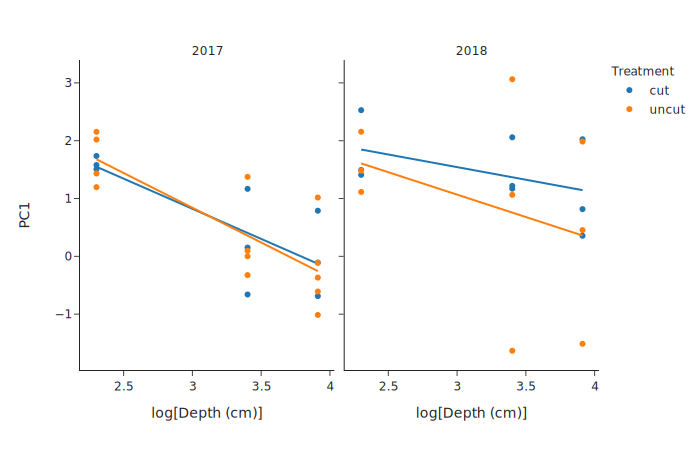

In [38]:
# Plot the relationship
fig_pc1 = px.scatter(df_soil, x = 'Depth_log', y = "PC1", facet_col = 'Year', color = 'Treatment', 
                     template = 'simple_white', trendline='ols')
fig_pc1.update_xaxes(title_text = 'log[Depth (cm)]')
fig_pc1.for_each_annotation(lambda a: a.update(text=a.text.split("=")[-1]))
fig_pc1.show()

## Is there a difference in source water use between grasses and trees?
### ANOVA of PC1 against Plant Type and Year
To answer this question, we can run an ANOVA with PC1 as the response variable and plant type and year as predictors using the df_plants dataframe defined during the PCA. In the output below, there is a difference between plant types, but no significant interaction with year. On average, trees tend to have smaller PC1 values and uptake water from deeper sources than grasses. 

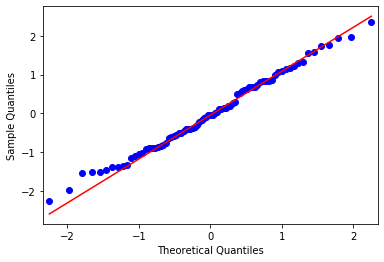

In [39]:
# define the sample type and year as categorical variables using 'C()'
# The dataframe 'df_plants' was defined above when graphing the pca bar graph
lm_type = smf.ols('PC1~C(Type_2)*C(Year)', data = df_plants).fit()

# Check the assumption of normality
qqplot(lm_type.resid, line='q', fit=True)
plt.show()

In [40]:
# run the ANOVA
anova_type = anova_lm(lm_type, typ=2)
anova_type

,sum_sq,df,F,PR(>F)
C(Type_2),43.644676,1.0,40.368059,1.353100e-08
C(Year),1.745954,1.0,1.614877,2.076336e-01
C(Type_2):C(Year),0.821527,1.0,0.759851,3.860852e-01
Residual,83.249977,77.0,NaN,NaN


## Is there a difference in source water use between cut and uncut trees?
### ANOVA of tree PC1 values against Treatment and Year
To answer this question, we can run an ANOVA with PC1 as the response and Treatment and Year as predictors using a dataframe that only includes tree samples. In the output below, there is a slightly significant difference between cut and uncut treatments (P = 0.02), but no significant interaction with year. On average, trees in the cut treatment have larger PC1 values and uptake water from shallower depths than trees in the uncut treatment. 

In [41]:
# subset the data to only include tree samples
df_tree = df.loc[(df['Type_2'] == 'tree')]

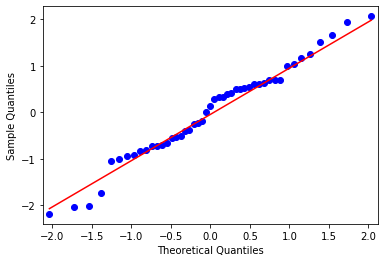

In [42]:
# define the treatment and year as categorical variables using 'C()'
lm_plants = smf.ols('PC1 ~ C(Treatment)*C(Year)', data=df_tree).fit()

# check the assumption of normality
qqplot(lm_plants.resid, line='q', fit=True)
plt.show()

In [43]:
# run the ANOVA
anova_statsmodels = anova_lm(lm_plants, typ=2)
anova_statsmodels

,sum_sq,df,F,PR(>F)
C(Treatment),4.230046,1.0,5.647887,0.021999
C(Year),0.141099,1.0,0.188392,0.666428
C(Treatment):C(Year),0.015690,1.0,0.020950,0.885593
Residual,32.205318,43.0,NaN,NaN
